In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations

import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score
from sklearn.decomposition import PCA

pd.set_option('future.no_silent_downcasting', True)

# Import data

two versions of df, and make lists of columns

In [2]:
df_og = pd.read_csv('data/df_combo.csv', index_col=0) # no standardisation, but categories combined

cont_cols = []
cat_cols = [col for col in df_og.columns if df_og[col].dtype=='object']

for col in df_og.columns:
    if ((df_og[col].dtype=="object") or (len(df_og[col].unique())<5)):
        if (df_og[col].dtype!="object"):
            cat_cols.append(col)
    else:
        cont_cols.append(col)

un_log_cols = ['age', 'Total_income', 'Years_employed']

log_cols = cont_cols.copy()

for col in un_log_cols:
    log_cols.append(f'log_{col}')
    log_cols.remove(col)

In [3]:
df = pd.read_csv('data/df_stand2.csv', index_col=0) # preprocessed and standardised data
df.head()

,Exited,gender,age,term_deposit,Own_car,Own_property,credit_score,tenure,balance,Unemployed,...,Family_status_Widow,Housing_type_House/Apartment,Housing_type_Rented or Social Housing,Housing_type_With parents,Occupation_type_High-skill,Occupation_type_Low-skill,Occupation_type_Other,log_age,log_Total_income,log_Years_employed
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,0.291924,0,1,1,-0.324265,-1.040811,-1.222766,0,...,False,False,True,False,False,False,True,3.761200,12.965712,2.597906
5008806,0,1,0.196638,0,1,1,-0.437972,-1.386822,0.120305,0,...,False,True,False,False,False,True,False,3.737670,11.630717,1.412154
5008808,1,1,0.291924,0,0,1,-1.533701,1.035252,1.335893,0,...,False,True,False,False,False,True,False,3.761200,12.506181,2.235735
5008812,0,1,0.006065,0,0,1,0.502700,-1.386822,-1.222766,1,...,False,True,False,False,False,False,True,3.688879,12.554971,0.000000
5008815,0,1,0.387210,0,1,1,2.063597,-1.040811,0.788620,0,...,False,True,False,False,True,False,False,3.784190,12.506181,1.133159


# Feature selection

## Correlation Analysis

### Continuous Variables

In [4]:
log_cols.append('Exited')

df[log_cols].corr()['Exited'].sort_values(ascending=False)

Exited                1.000000
log_age               0.293955
balance               0.118961
Num_children          0.012055
Account_length        0.008249
log_Years_employed    0.003704
log_Total_income      0.003677
tenure               -0.012370
credit_score         -0.026100
Name: Exited, dtype: float64

#### Check for correlations between all continuous variables

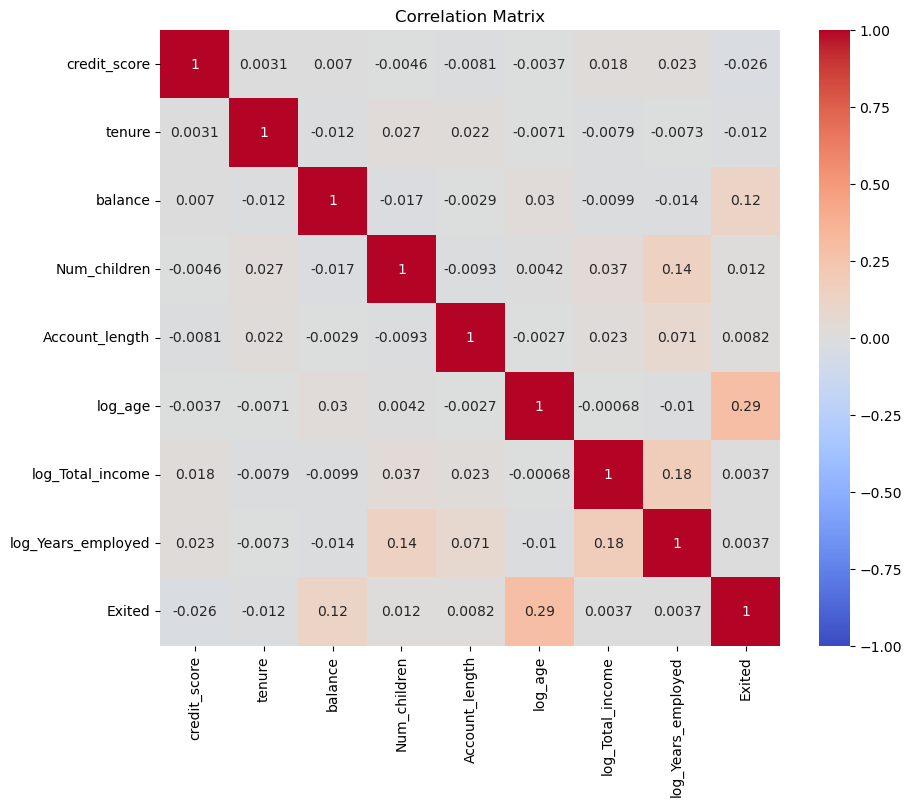

In [5]:
df_cont = df[log_cols]
corr_matrix = df_cont.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

## Categorical Variables

using chi-square and cramer's V

In [6]:
chi_square_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(df_og[col], df_og['Exited'])

    # Perform the Chi-Square test
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)

    # Store the results
    chi_square_results[col] = p_val

# sort dictionary
sorted_chi = {key: value for key, value in sorted(chi_square_results.items(), 
                                    key=lambda item: item[1])}

print("\nSummary of p-values for each categorical variable:")
for key, value in sorted_chi.items():
    print(f"{key}: p-value = {value}")


Summary of p-values for each categorical variable:
Exited: p-value = 0.0
Geography: p-value = 4.6684266529438565e-62
gender: p-value = 1.6550622347096856e-25
Family_status: p-value = 0.05784973437880665
Own_property: p-value = 0.2796983374835178
Education_type: p-value = 0.337372505424993
Housing_type: p-value = 0.3807181114004294
credit_card: p-value = 0.48242290160988577
Occupation_type: p-value = 0.5538342796694881
Target: p-value = 0.5749204901726583
Income_type: p-value = 0.584526832016826
Unemployed: p-value = 0.6474792631444766
term_deposit: p-value = 0.7564630606645011
Own_car: p-value = 0.902321549792948


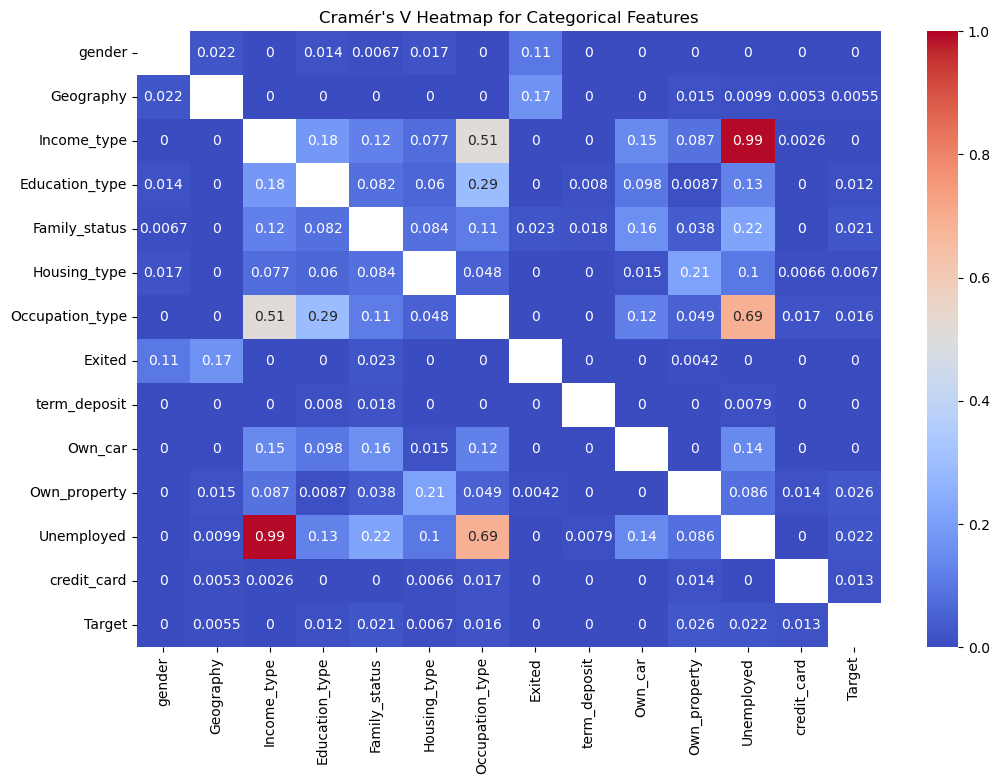

In [7]:
def cramers_v(confusion_mat):
    chi2 = stats.chi2_contingency(confusion_mat)[0]
    n = confusion_mat.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_mat.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

# Loop through each pair of categorical columns and calculate Cramér's V
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 != col2:
            # Create a contingency table
            confusion_mat = pd.crosstab(df_og[col1], df_og[col2])
            # Calculate Cramér's V
            cramers_v_matrix.at[col1, col2] = cramers_v(confusion_mat)
        else:
            cramers_v_matrix.at[col1, col2] = np.nan  # Fill diagonal with NaN

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(12, 8))  
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title('Cramér\'s V Heatmap for Categorical Features')
plt.show()

## Random Forest for Feature Importance

In [8]:
X = df.drop(columns=un_log_cols)
X = X.drop(columns=['Exited'])
y = df['Exited']

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Display the most important features
feature_importances_sorted

,Feature,Importance
31,log_age,0.195158
4,credit_score,0.104150
6,balance,0.095660
9,Account_length,0.088686
33,log_Years_employed,0.081471
32,log_Total_income,0.079971
5,tenure,0.063351
8,Num_children,0.023603
14,Geography_Netherlands,0.017625
0,gender,0.017300


## Features Selected

Assumption - Changes by geography are due to local economic and political situations, not customer behaviour, and thus not something the bank can change, so it will be eliminated.

In [10]:
# features suggested by correlation analysis
corr_features = ['log_age', 'balance', 'gender']

# features suggested by random forest
forest_features = ['log_age', 'credit_score', 'balance', 'Account_length', 
                   'log_Years_employed', 'log_Total_income', 'tenure']

# Models

In [11]:
y = df['Exited']

In [12]:
cols = [corr_features, forest_features]
models = ['Correlation Analysis', 'Feature Importance']

Try and find best number of clusters

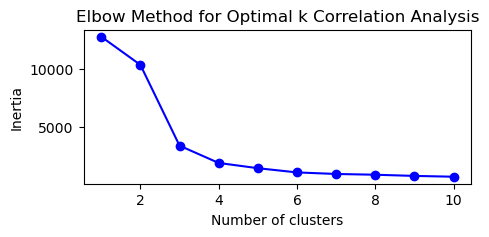

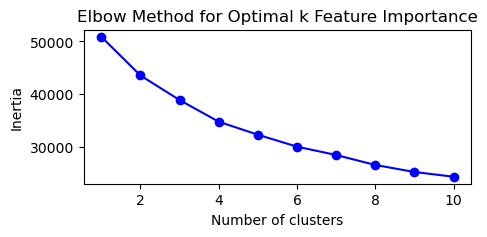

In [13]:
for model, col in zip(models, cols):
    X_m = df[col]

    # elbow method
    inertia = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_m)
        inertia.append(kmeans.inertia_)
    
    # Plot the Elbow curve
    plt.figure(figsize=(5, 2))
    plt.plot(K_range, inertia, 'bo-')
    plt.title(f'Elbow Method for Optimal k {model}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

Looks like two through 4 ish

In [14]:
for model, col in zip(models, cols):
    X_m = df[col]

    for j in range(2, 5):
        kmeans = KMeans(n_clusters=j, random_state=42)
        kmeans.fit(X_m)

        df_og[f'{model} Model Clusters k={j}'] = kmeans.labels_

        record_counts = df_og.groupby(f'{model} Model Clusters k={j}').size()
        exit_counts = df_og.groupby(f'{model} Model Clusters k={j}')['Exited'].value_counts(normalize=True)
        print(f'Exit Counts:\n{exit_counts}\n')
        print(f'Record Counts:\n{record_counts}\n')

Exit Counts:
Correlation Analysis Model Clusters k=2  Exited
0                                        0         0.834942
                                         1         0.165058
1                                        0         0.748983
                                         1         0.251017
Name: proportion, dtype: float64

Record Counts:
Correlation Analysis Model Clusters k=2
0    5283
1    4426
dtype: int64

Exit Counts:
Correlation Analysis Model Clusters k=3  Exited
0                                        0         0.759912
                                         1         0.240088
1                                        0         0.888725
                                         1         0.111275
2                                        0         0.809252
                                         1         0.190748
Name: proportion, dtype: float64

Record Counts:
Correlation Analysis Model Clusters k=3
0    5927
1    2031
2    1751
dtype: int64

Exit Counts:
Correlati

## Refinement

The most promising model is Feature Importance Model Clusters k=4, with two clusters over 24% exit rates.

### Examine the model

In [15]:
model = 'Feature Importance Model Clusters k=4'

In [16]:
# Group by cluster and calculate the mean for each feature
df_cont = df_og[cont_cols]
df_cont = df_cont.assign(**{
    model: df_og[model]
})

cluster_summary = df_cont.groupby(model).mean()
cluster_summary

,age,credit_score,tenure,balance,Num_children,Account_length,Total_income,Years_employed
Feature Importance Model Clusters k=4,,,,,,,,
0,38.888842,656.885067,5.194211,66235.101397,0.447148,48.119547,191076.187500,8.475554
1,39.417678,647.156412,7.610052,123882.669185,0.422444,21.416378,176556.002600,4.223117
2,39.095913,650.021685,2.322352,122218.669696,0.384487,20.949124,176710.599458,5.151878
3,38.409317,647.587247,5.004582,1488.571707,0.436044,19.237495,180517.616838,4.846119


In [17]:
# Calculate the counts for each category within each cluster
for feature in cat_cols:
    feature_counts = pd.crosstab(df_og[model], df_og[feature], normalize='index') * 100
    print(f"\n{feature} by Cluster:")
    print(feature_counts)


gender by Cluster:
gender                                    Female       Male
Feature Importance Model Clusters k=4                      
0                                      45.469799  54.530201
1                                      44.324090  55.675910
2                                      46.705588  53.294412
3                                      45.780832  54.219168

Geography by Cluster:
Geography                                 Greece  Netherlands      Spain
Feature Importance Model Clusters k=4                                   
0                                      51.593960    24.286913  24.119128
1                                      40.857886    38.648180  20.493934
2                                      40.867389    39.282736  19.849875
3                                      65.559374     0.610920  33.829706

Income_type by Cluster:
Income_type                            Commercial associate  \
Feature Importance Model Clusters k=4                         
0       

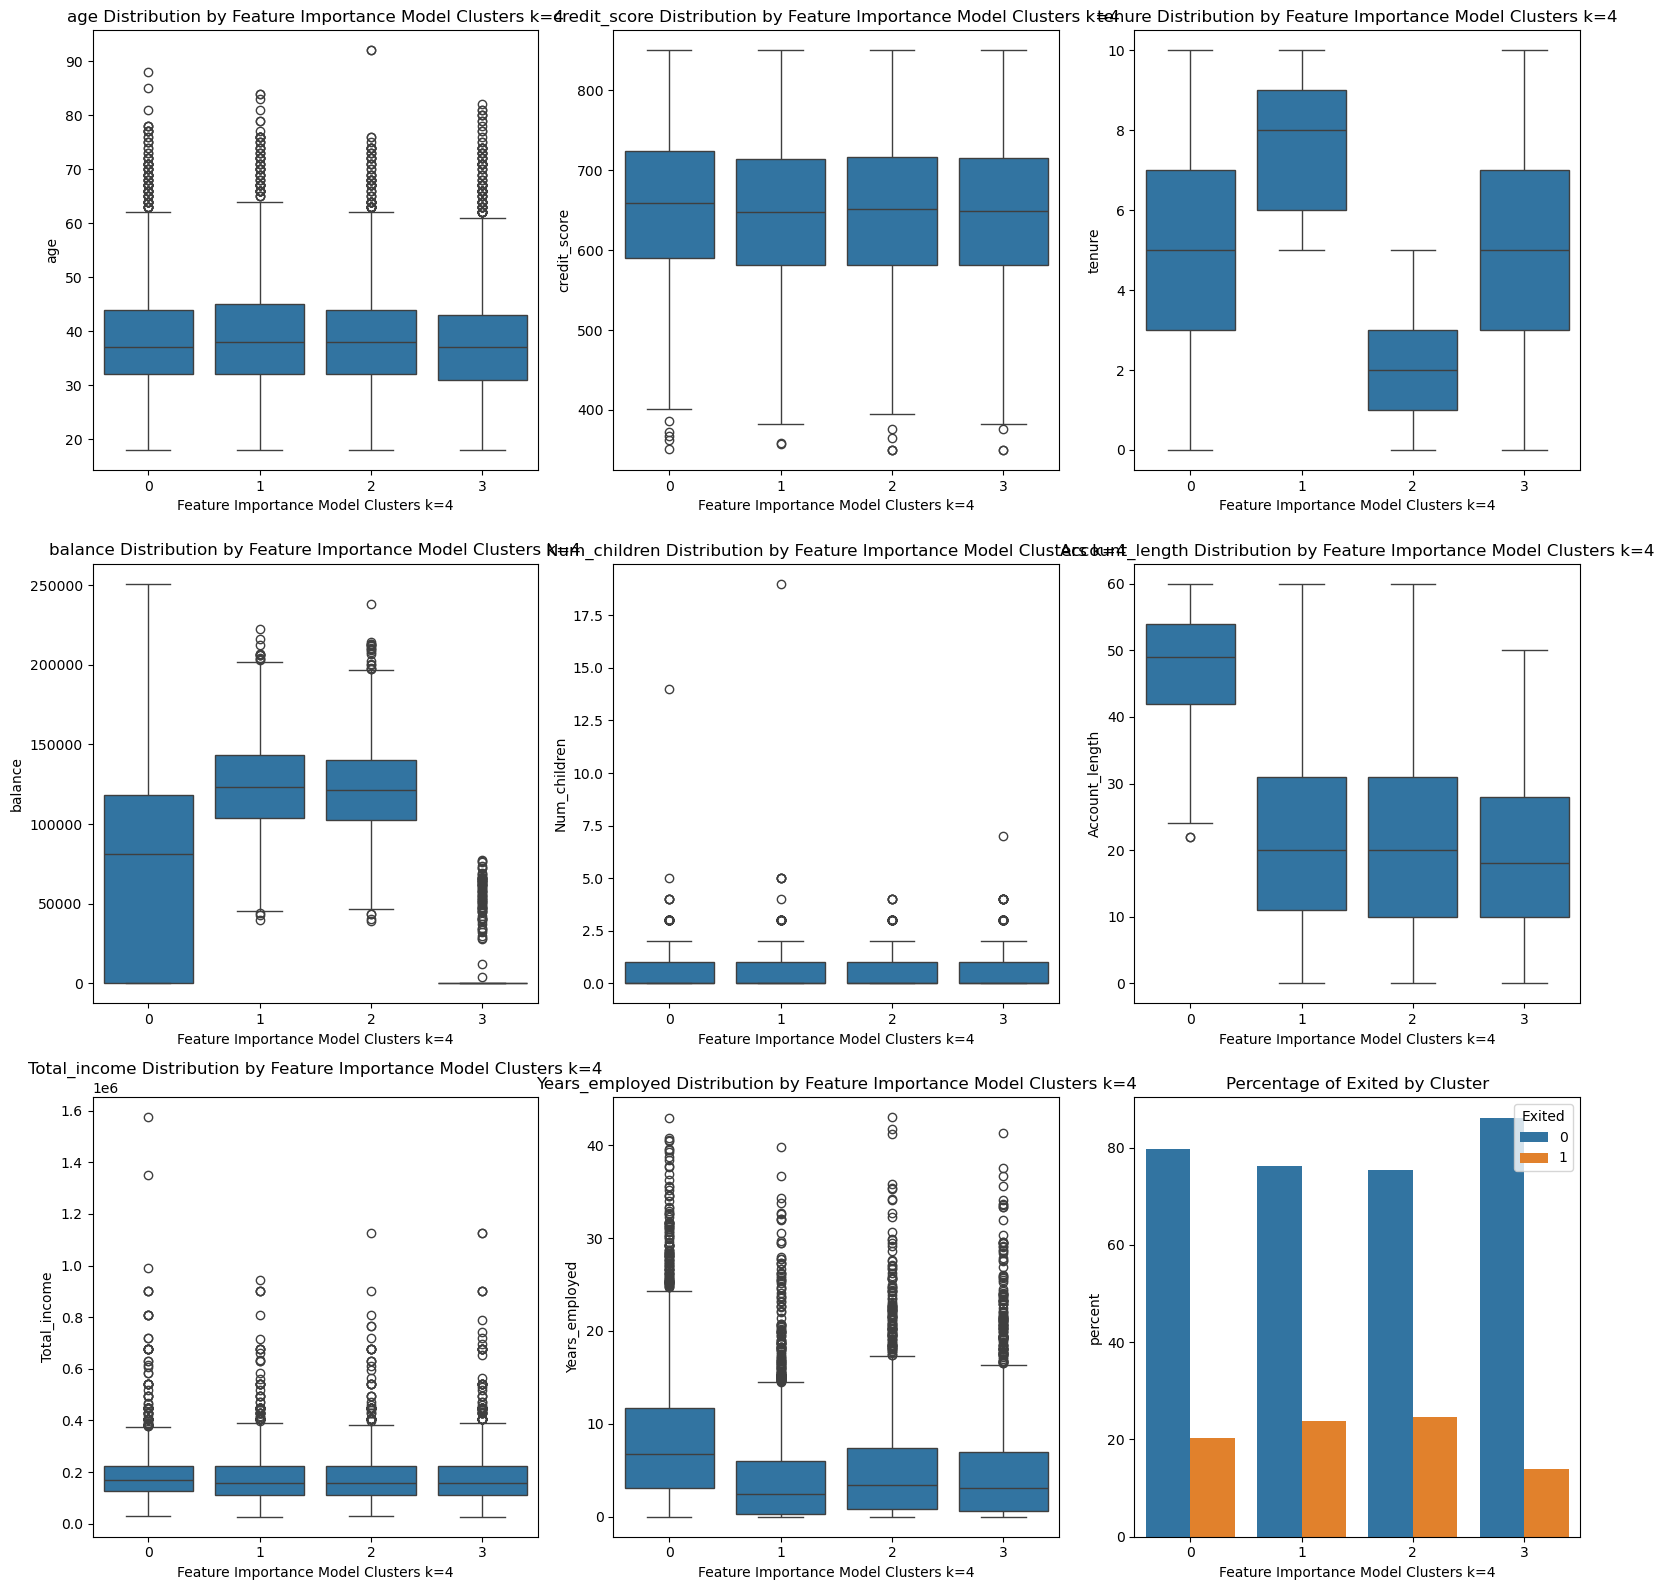

In [18]:
# Plot boxplots for each feature by cluster
# List of columns to plot
columns = cont_cols

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

# Plot each feature in the grid
for i, col in enumerate(columns):
    sns.boxplot(x=model, y=col, data=df_og, ax=axes[i])
    axes[i].set_title(f'{col} Distribution by {model}')

# Plot the bar chart in the last subplot
exit_counts = df_og.groupby(model)['Exited'].value_counts(normalize=True)
exit_counts = exit_counts.mul(100).reset_index(name='percent')
sns.barplot(x=model, y='percent', hue='Exited', data=exit_counts, ax=axes[-1])
axes[-1].set_title('Percentage of Exited by Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

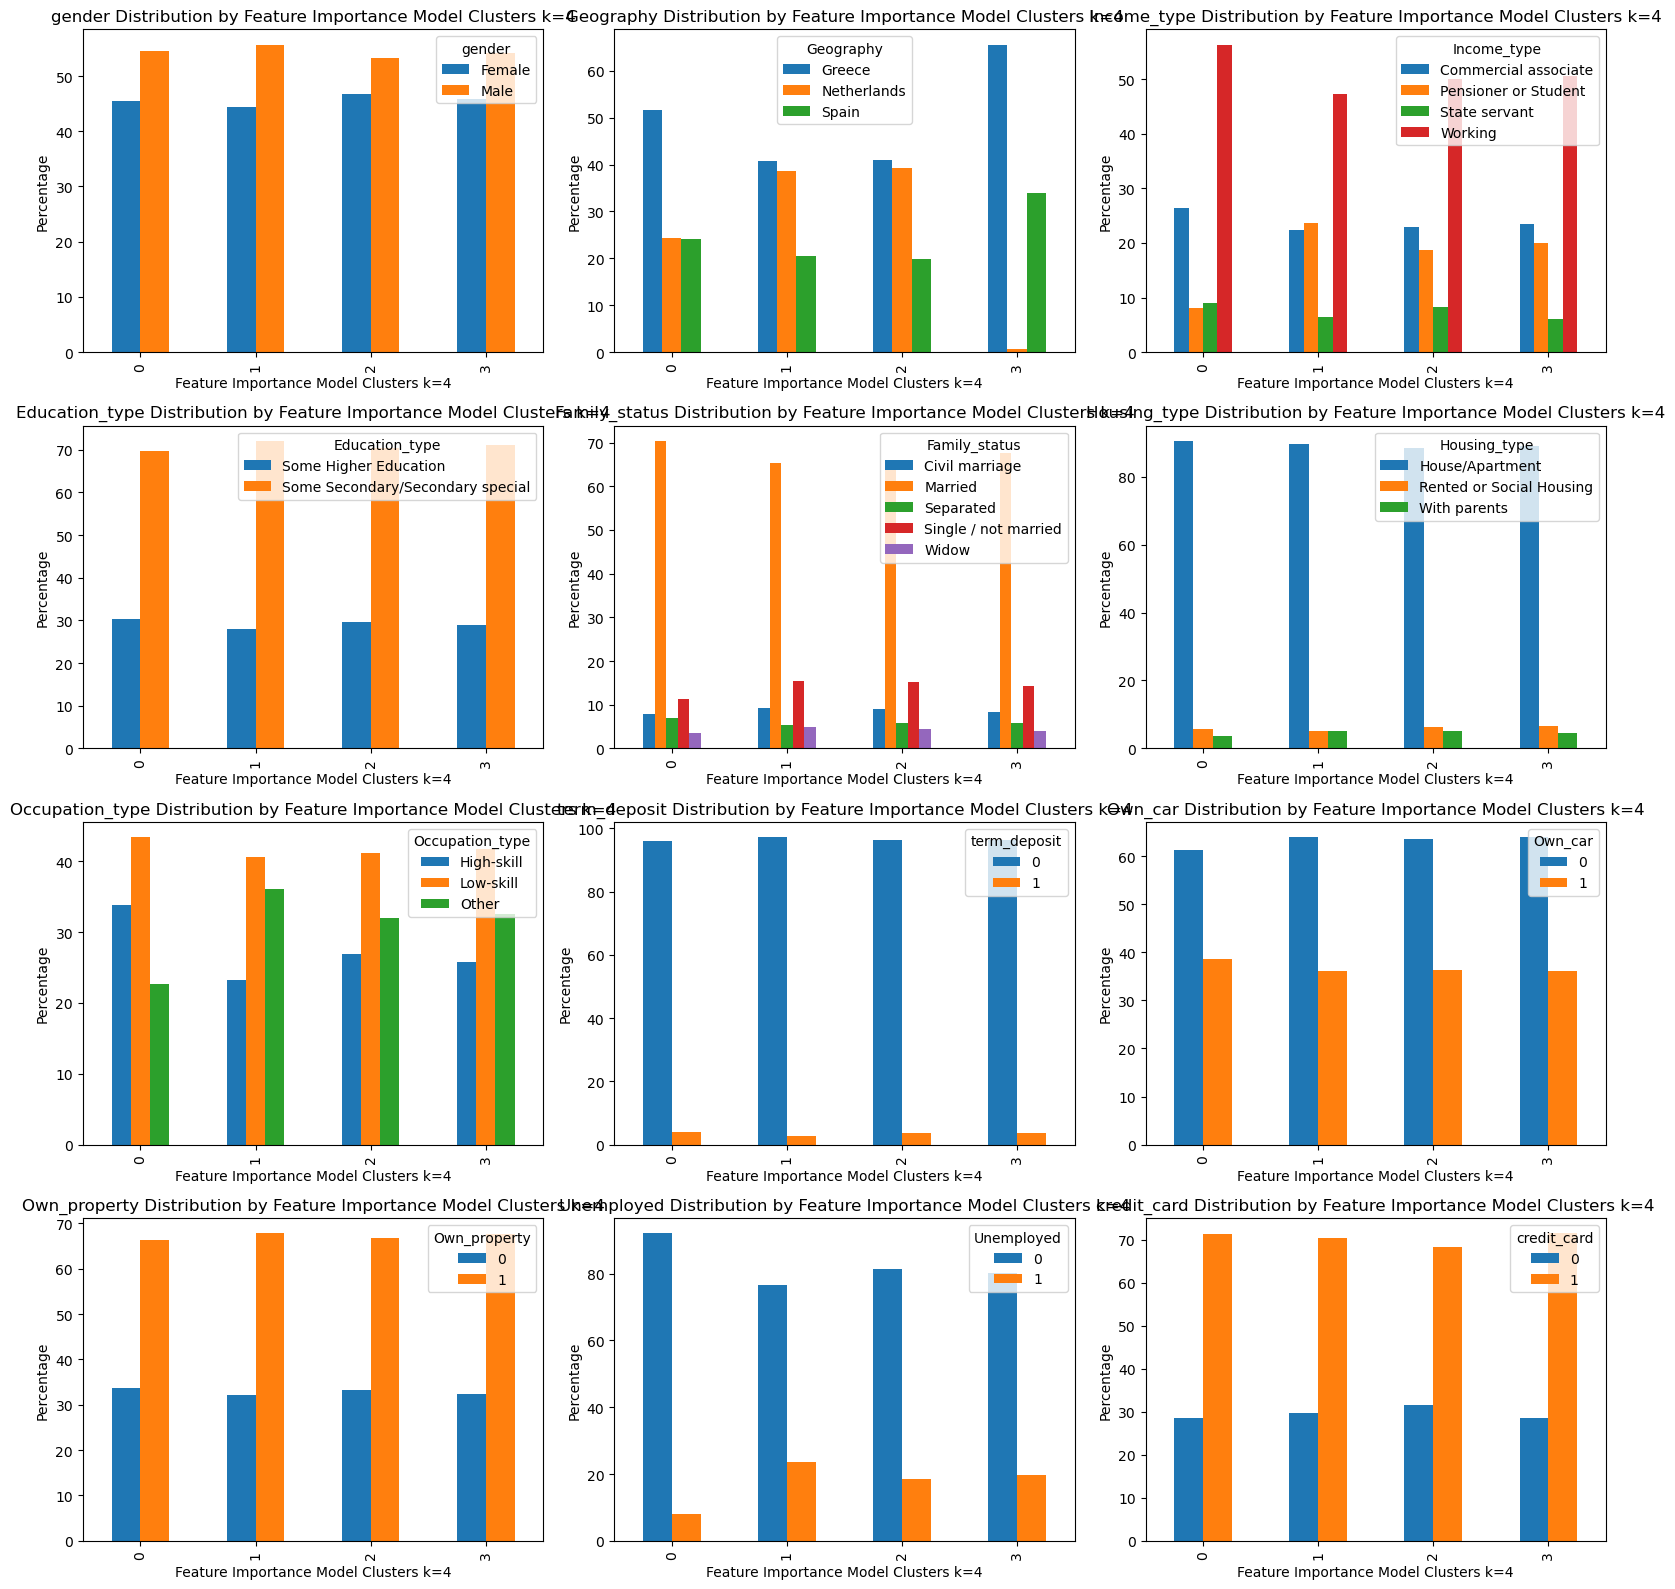

In [19]:
# plot the categorical features
cat_cols.remove('Exited')
cat_cols.remove('Target')

# Set up the figure and axes for a 3x5 grid
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
axes = axes.flatten()

# Plot each categorical feature as a stacked bar chart
for i, feature in enumerate(cat_cols):
    # Calculate the percentage distribution for each feature by 'Cluster k=3'
    feature_counts = pd.crosstab(df_og[model], df_og[feature], normalize='index') * 100
    
    # Plot the stacked bar chart on the ith subplot
    feature_counts.plot(kind='bar', ax=axes[i], legend=False)
    axes[i].set_title(f'{feature} Distribution by {model}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel(model)

    # add legend
    axes[i].legend(title=feature, loc='best')

# Adjust layout
plt.tight_layout()

plt.show()

gender does not vary between clusters so does not seem to be a good feature.
credit score doesn't vary between clusters either, nore does total income.
age does not seem to vary, but it scores highly on all feature importance tests, so it remains in the feature selection, especially as it varies in other models

In [20]:
forest_features

['log_age',
 'credit_score',
 'balance',
 'Account_length',
 'log_Years_employed',
 'log_Total_income',
 'tenure']

In [21]:
new_features = ['log_age', 'tenure', 'balance', 'Account_length', 'log_Years_employed']

In [22]:
cols.append(new_features)
models.append('Refined Features')

In [23]:
for model, col in zip(models, cols):
    X_m = df[col]

    for j in range(3, 5):
        kmeans = KMeans(n_clusters=j, random_state=42)
        kmeans.fit(X_m)

        df_og[f'{model} Model Clusters k={j}'] = kmeans.labels_

        record_counts = df_og.groupby(f'{model} Model Clusters k={j}').size()
        exit_counts = df_og.groupby(f'{model} Model Clusters k={j}')['Exited'].value_counts(normalize=True)
        print(f'Exit Counts:\n{exit_counts}\n')
        print(f'Record Counts:\n{record_counts}\n')

Exit Counts:
Correlation Analysis Model Clusters k=3  Exited
0                                        0         0.759912
                                         1         0.240088
1                                        0         0.888725
                                         1         0.111275
2                                        0         0.809252
                                         1         0.190748
Name: proportion, dtype: float64

Record Counts:
Correlation Analysis Model Clusters k=3
0    5927
1    2031
2    1751
dtype: int64

Exit Counts:
Correlation Analysis Model Clusters k=4  Exited
0                                        0         0.800731
                                         1         0.199269
1                                        0         0.891054
                                         1         0.108946
2                                        0         0.811951
                                         1         0.188049
3                        

In [24]:
model = 'Refined Features Model Clusters k=4'

In [25]:
# Group by cluster and calculate the mean for each feature
df_cont = df_og[cont_cols]
df_cont = df_cont.assign(**{
    model: df_og[model]
})

cluster_summary = df_cont.groupby(model).mean()
cluster_summary

,age,credit_score,tenure,balance,Num_children,Account_length,Total_income,Years_employed
Refined Features Model Clusters k=4,,,,,,,,
0,38.926458,653.572237,5.290252,82921.572933,0.473455,46.302002,193704.297650,9.651445
1,39.113919,650.442439,4.718813,123255.808684,0.490574,15.074208,188668.265343,7.357250
2,39.548111,647.807053,5.063476,120833.218358,0.263476,27.770277,158649.086902,0.476596
3,38.379134,649.531197,4.995227,1063.817712,0.433345,22.386294,180410.379134,4.613766


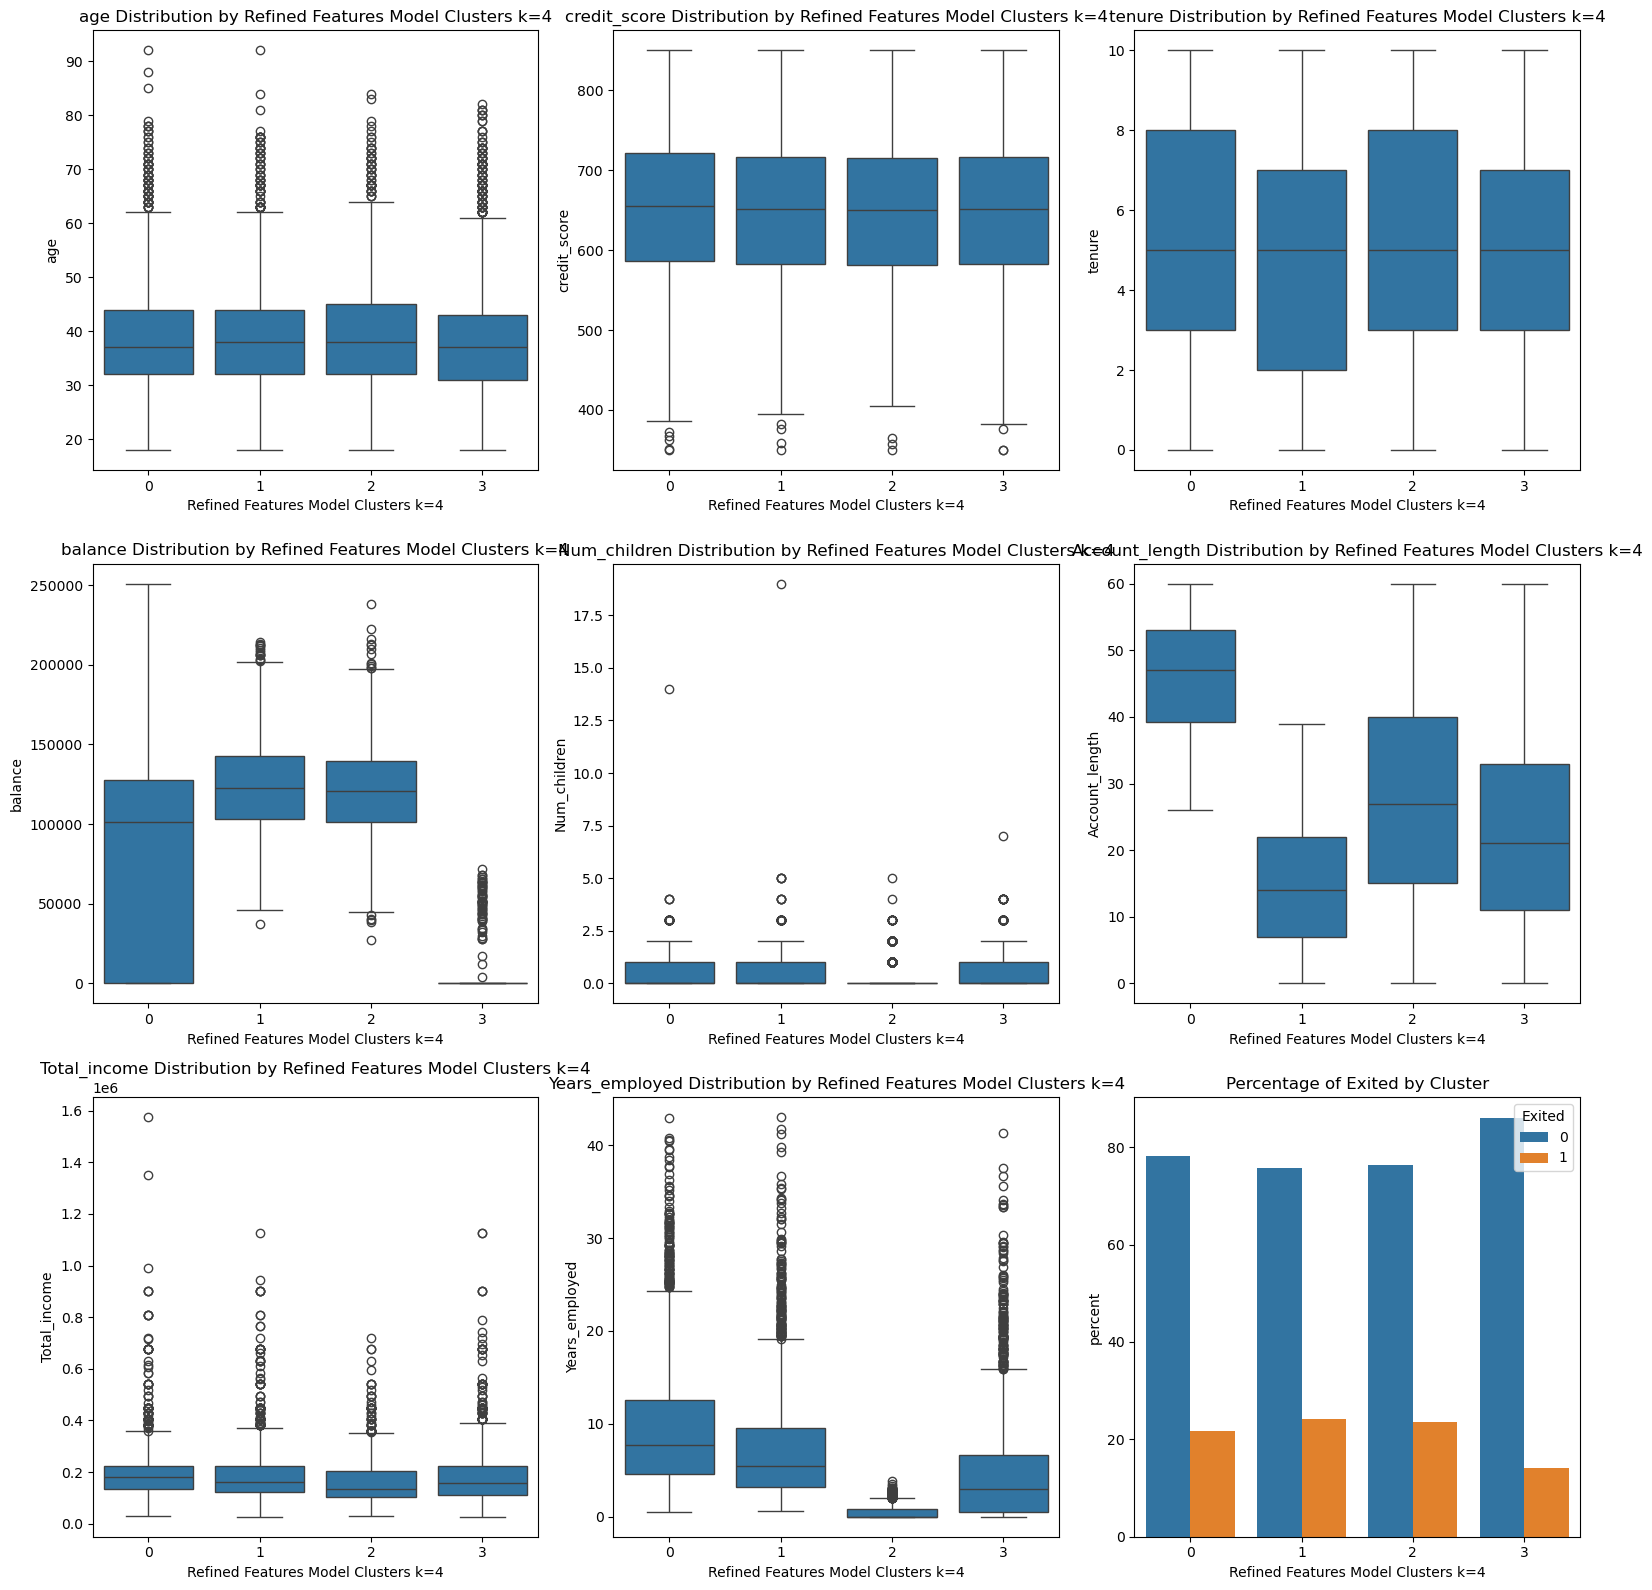

In [26]:
# Plot boxplots for each feature by cluster
# List of columns to plot
columns = cont_cols

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

# Plot each feature in the grid
for i, col in enumerate(columns):
    sns.boxplot(x=model, y=col, data=df_og, ax=axes[i])
    axes[i].set_title(f'{col} Distribution by {model}')

# Plot the bar chart in the last subplot
exit_counts = df_og.groupby(model)['Exited'].value_counts(normalize=True)
exit_counts = exit_counts.mul(100).reset_index(name='percent')
sns.barplot(x=model, y='percent', hue='Exited', data=exit_counts, ax=axes[-1])
axes[-1].set_title('Percentage of Exited by Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
new_features2 = ['log_age', 'tenure', 'Account_length', 'log_Years_employed']

In [28]:
cols.append(new_features2)
models.append('Refined Features2')

In [29]:
for model, col in zip(models, cols):
    X_m = df[col]

    for j in range(3, 5):
        kmeans = KMeans(n_clusters=j, random_state=42)
        kmeans.fit(X_m)

        df_og[f'{model} Model Clusters k={j}'] = kmeans.labels_

        record_counts = df_og.groupby(f'{model} Model Clusters k={j}').size()
        exit_counts = df_og.groupby(f'{model} Model Clusters k={j}')['Exited'].value_counts(normalize=True)
        print(f'Exit Counts:\n{exit_counts}\n')
        print(f'Record Counts:\n{record_counts}\n')

Exit Counts:
Correlation Analysis Model Clusters k=3  Exited
0                                        0         0.759912
                                         1         0.240088
1                                        0         0.888725
                                         1         0.111275
2                                        0         0.809252
                                         1         0.190748
Name: proportion, dtype: float64

Record Counts:
Correlation Analysis Model Clusters k=3
0    5927
1    2031
2    1751
dtype: int64

Exit Counts:
Correlation Analysis Model Clusters k=4  Exited
0                                        0         0.800731
                                         1         0.199269
1                                        0         0.891054
                                         1         0.108946
2                                        0         0.811951
                                         1         0.188049
3                        

### Rethink

This didn't work, let's try different combinations of features and find the simplest model that meets or nearly meets the criteria

In [30]:
features = forest_features

# Loop through different sizes of feature combinations
for r in range(2, len(features) + 1):  # Start from combinations of size 2
    for feature_combo in combinations(features, r):
        print(f'Testing combination: {feature_combo}')
        X_m = df[list(feature_combo)]

        for j in range(3, 5):  # Number of clusters
            kmeans = KMeans(n_clusters=j, random_state=42)
            kmeans.fit(X_m)

            df['Clusters'] = kmeans.labels_

            # Calculate exit counts and record counts
            record_counts = df.groupby('Clusters').size()
            exit_counts = df.groupby('Clusters')['Exited'].value_counts(normalize=True)

            print(f'\nCluster Analysis for combination {feature_combo} with k={j}:')
            print(f'Exit Counts:\n{exit_counts}\n')

Testing combination: ('log_age', 'credit_score')

Cluster Analysis for combination ('log_age', 'credit_score') with k=3:
Exit Counts:
Clusters  Exited
0         0         0.801878
          1         0.198122
1         0         0.784321
          1         0.215679
2         0         0.797670
          1         0.202330
Name: proportion, dtype: float64


Cluster Analysis for combination ('log_age', 'credit_score') with k=4:
Exit Counts:
Clusters  Exited
0         0         0.809129
          1         0.190871
1         0         0.773844
          1         0.226156
2         0         0.798310
          1         0.201690
3         0         0.793115
          1         0.206885
Name: proportion, dtype: float64

Testing combination: ('log_age', 'balance')

Cluster Analysis for combination ('log_age', 'balance') with k=3:
Exit Counts:
Clusters  Exited
0         0         0.758032
          1         0.241968
1         0         0.856149
          1         0.143851
2         0     

In [31]:
final_features = ['balance', 'log_Total_income']

X_m = df[list(final_features)]

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_m)

df_og['Final Model Clusters k=3'] = kmeans.labels_

record_counts = df_og.groupby('Final Model Clusters k=3').size()
exit_counts = df_og.groupby('Final Model Clusters k=3')['Exited'].value_counts(normalize=True)

print(f'Exit Counts:\n{exit_counts}\n')
print(f'Record Counts:\n{record_counts}\n')

Exit Counts:
Final Model Clusters k=3  Exited
0                         0         0.764470
                          1         0.235530
1                         0         0.855005
                          1         0.144995
2                         0         0.754039
                          1         0.245961
Name: proportion, dtype: float64

Record Counts:
Final Model Clusters k=3
0    3248
1    3676
2    2785
dtype: int64



# Profiles in Final Model

Comparing clusters 0 and 2

In [32]:
model = 'Final Model Clusters k=3'

In [33]:
# Group by cluster and calculate the mean for each feature
df_cont = df_og[cont_cols]
df_cont = df_cont.assign(**{
    model: df_og[model]
})

cluster_summary = df_cont.groupby(model).mean()
cluster_summary

,age,credit_score,tenure,balance,Num_children,Account_length,Total_income,Years_employed
Final Model Clusters k=3,,,,,,,,
0,39.324815,649.604064,5.000924,121939.111127,0.400246,26.767549,116703.372691,4.917012
1,38.502720,649.215180,5.047062,1998.248360,0.440696,27.441785,181641.130169,5.845095
2,39.055655,652.784560,4.964811,121149.309706,0.425494,27.629443,255935.077917,6.298686


In [34]:
# Calculate the counts for each category within each cluster
for feature in cat_cols:
    feature_counts = pd.crosstab(df_og[model], df_og[feature], normalize='index') * 100
    print(f"\n{feature} by Cluster:")
    print(feature_counts)


gender by Cluster:
gender                       Female       Male
Final Model Clusters k=3                      
0                         45.689655  54.310345
1                         46.137106  53.862894
2                         44.739677  55.260323

Geography by Cluster:
Geography                    Greece  Netherlands      Spain
Final Model Clusters k=3                                   
0                         40.517241    40.055419  19.427340
1                         66.050054     1.224157  32.725789
2                         40.430880    38.886894  20.682226

Income_type by Cluster:
Income_type               Commercial associate  Pensioner or Student  \
Final Model Clusters k=3                                               
0                                    17.733990             24.168719   
1                                    24.238303             16.947769   
2                                    30.341113             11.023339   

Income_type               State serv

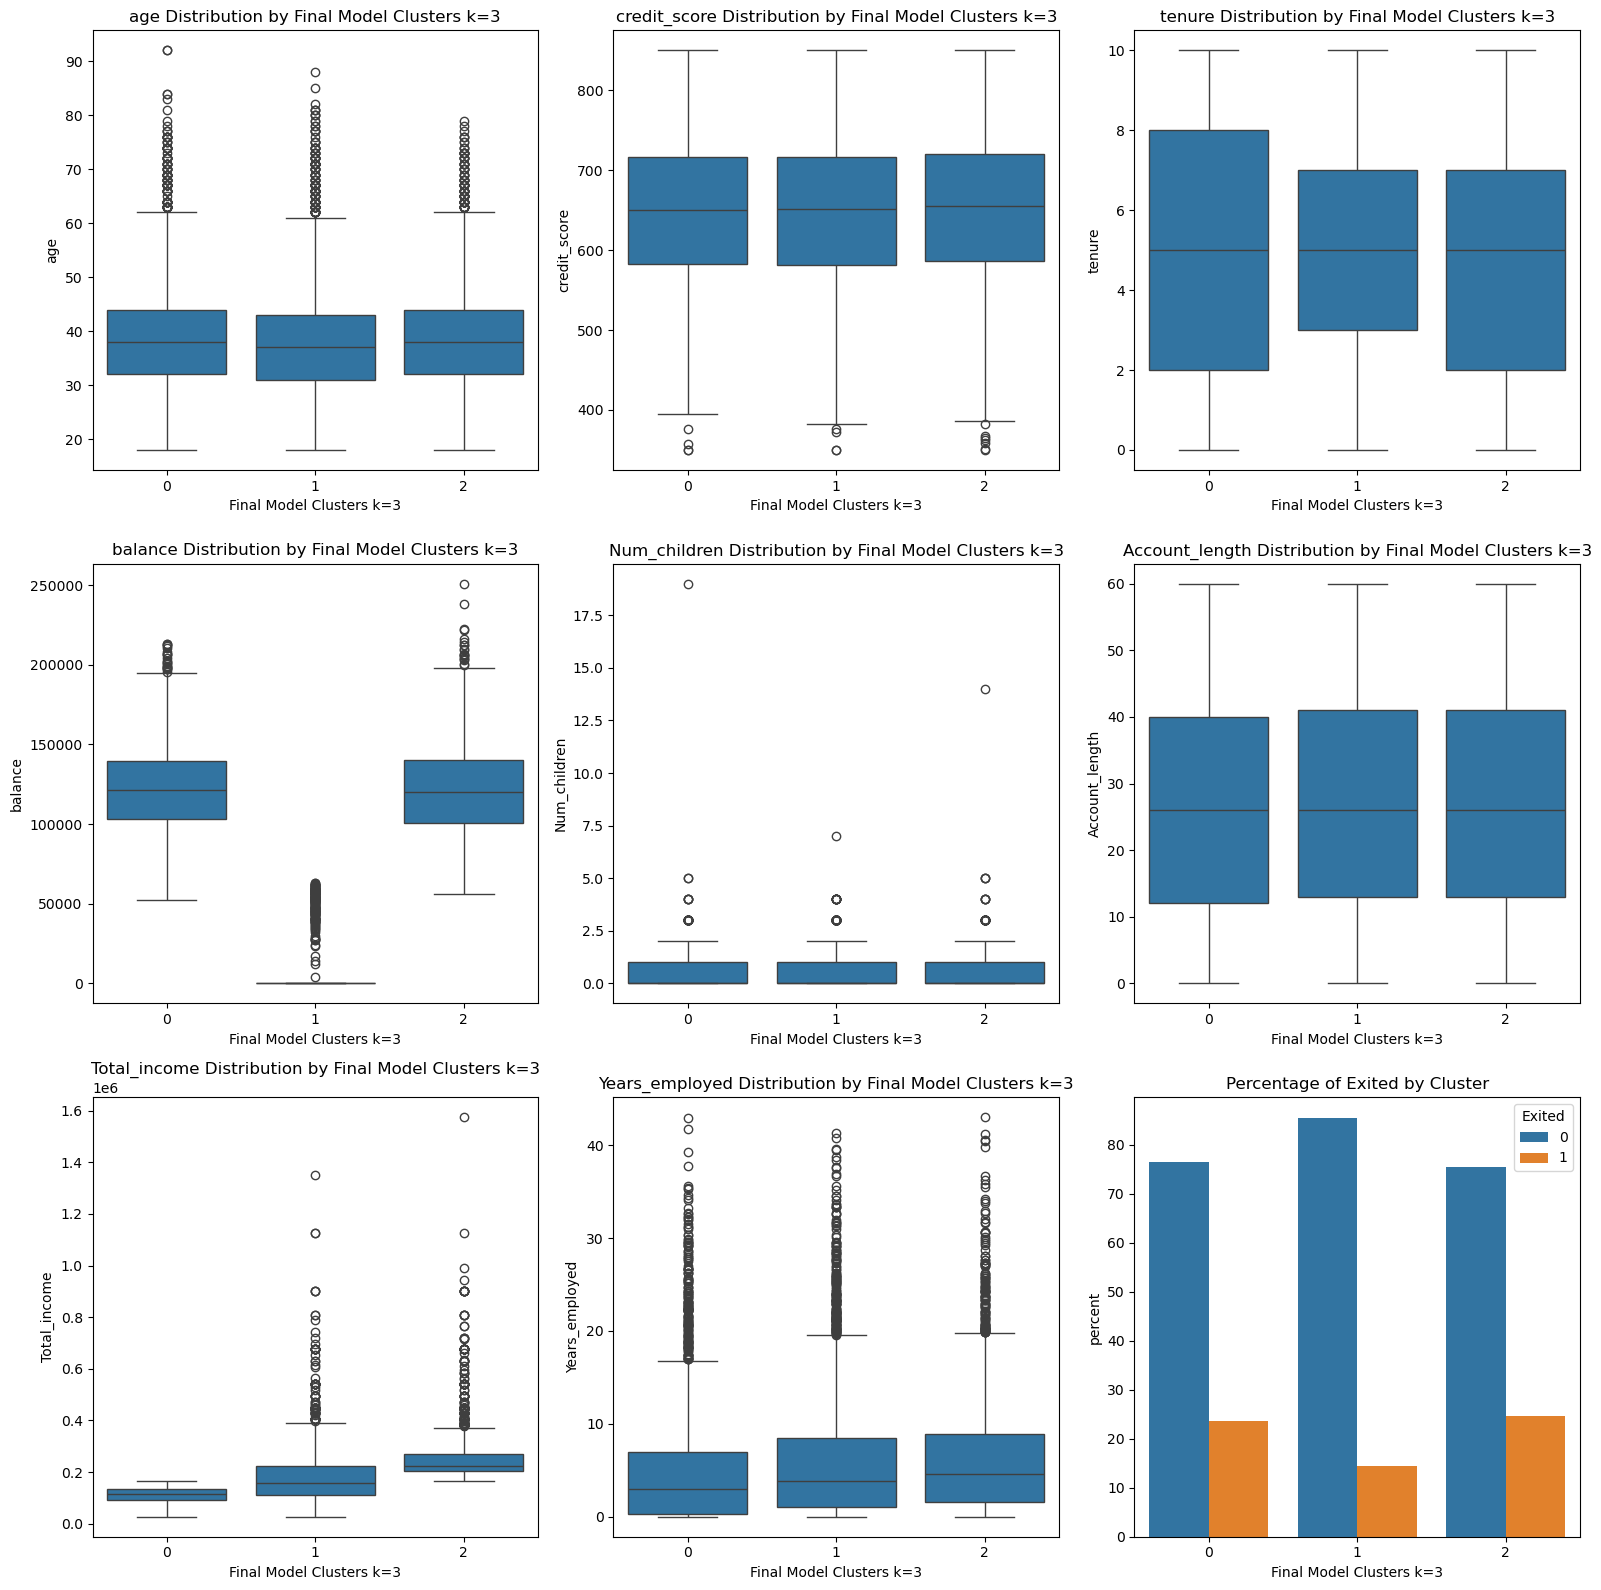

In [36]:
# Plot boxplots for each feature by cluster
# List of columns to plot
columns = cont_cols

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

# Plot each feature in the grid
for i, col in enumerate(columns):
    sns.boxplot(x=model, y=col, data=df_og, ax=axes[i])
    axes[i].set_title(f'{col} Distribution by {model}')

# Plot the bar chart in the last subplot
exit_counts = df_og.groupby(model)['Exited'].value_counts(normalize=True)
exit_counts = exit_counts.mul(100).reset_index(name='percent')
sns.barplot(x=model, y='percent', hue='Exited', data=exit_counts, ax=axes[-1])
axes[-1].set_title('Percentage of Exited by Cluster')

# Adjust layout
plt.tight_layout()
plt.savefig('final_cont.jpg')
plt.show()

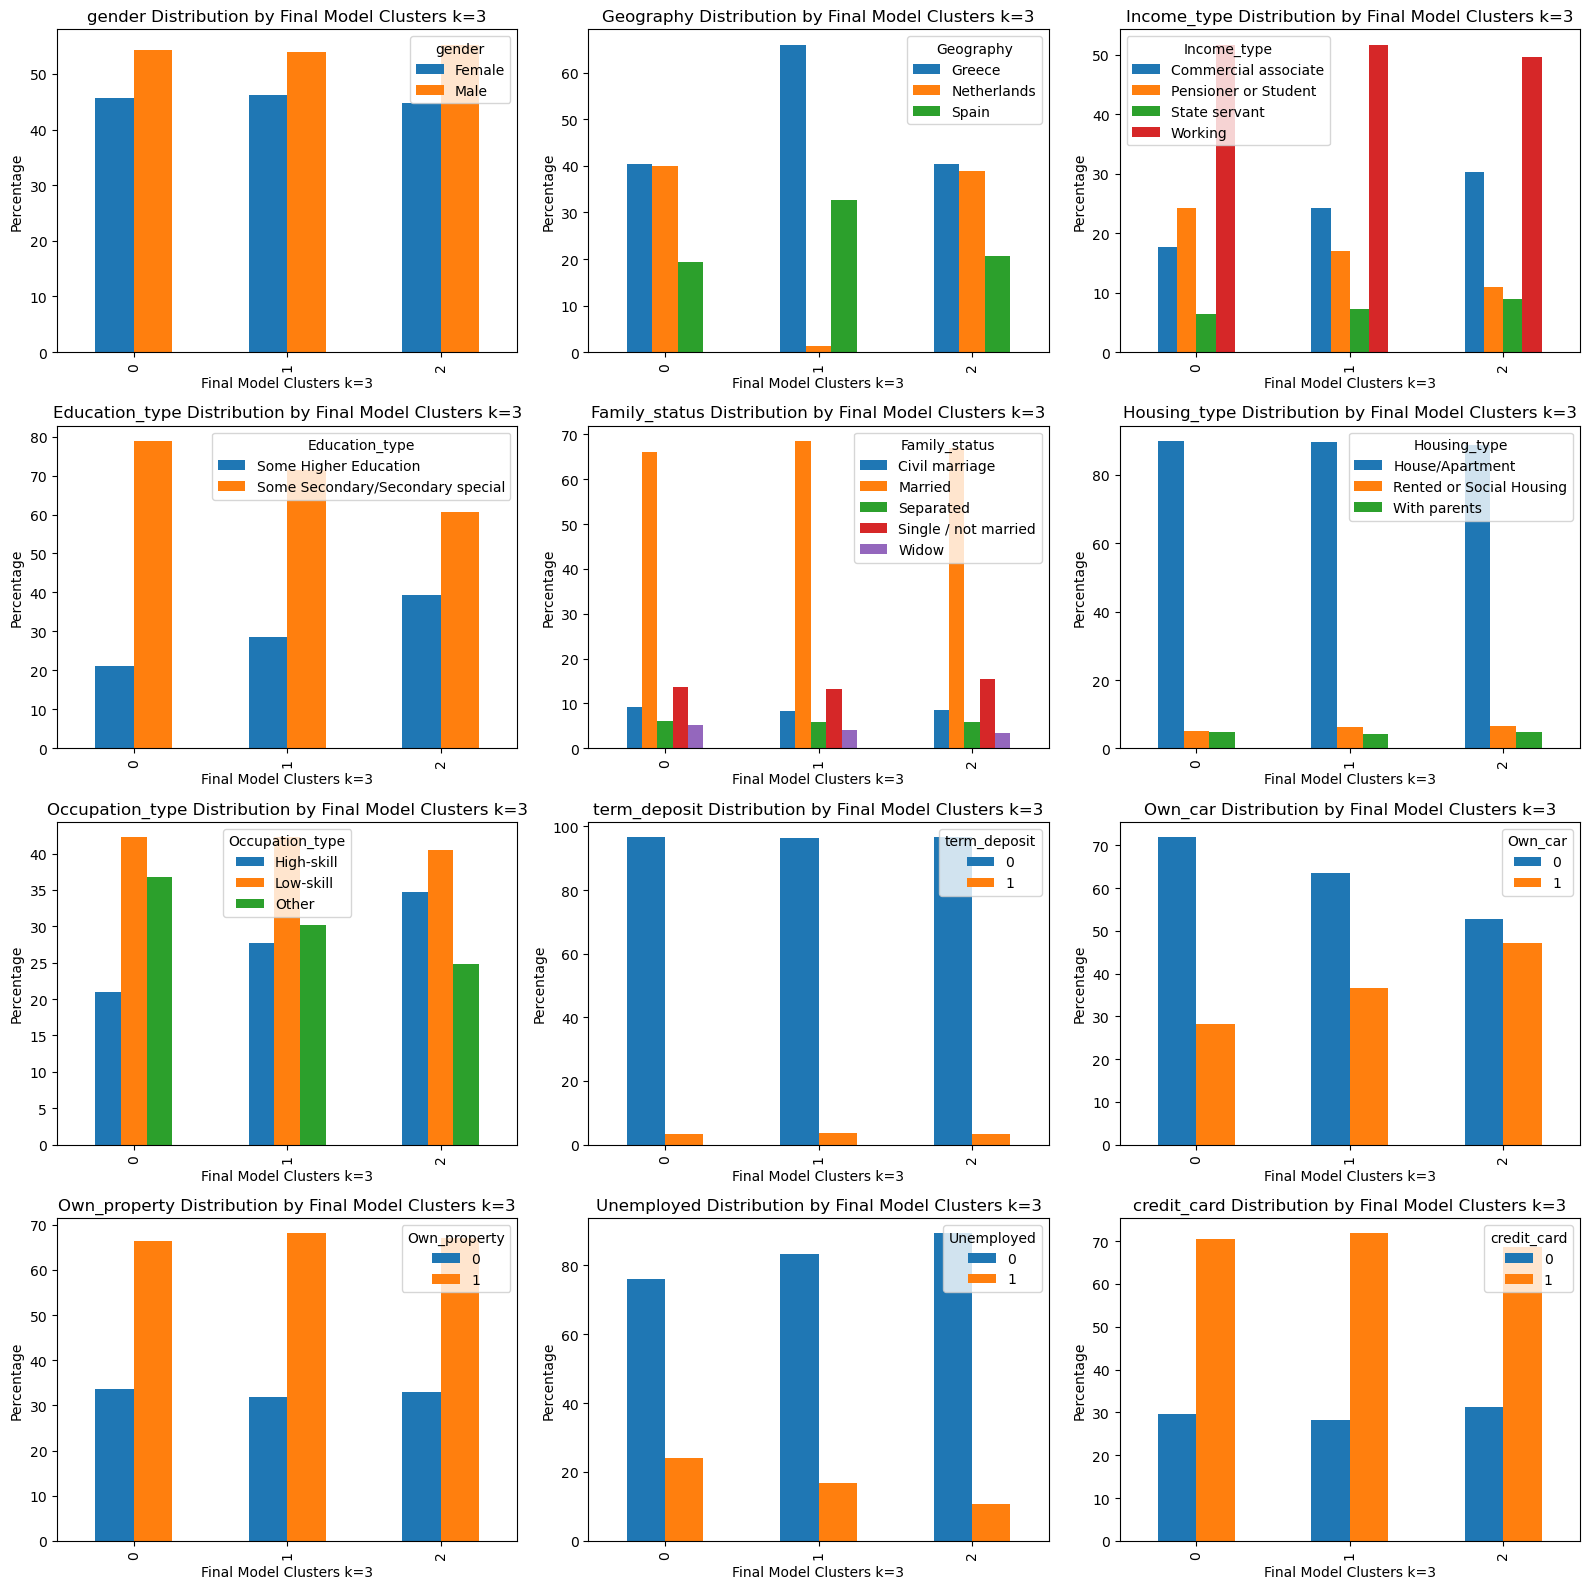

In [37]:
# plot the categorical features

fig, axes = plt.subplots(4, 3, figsize=(16, 16))
axes = axes.flatten()

# Plot each categorical feature as a stacked bar chart
for i, feature in enumerate(cat_cols):
    # Calculate the percentage distribution for each feature by 'Cluster k=3'
    feature_counts = pd.crosstab(df_og[model], df_og[feature], normalize='index') * 100
    
    # Plot the stacked bar chart on the ith subplot
    feature_counts.plot(kind='bar', ax=axes[i], legend=False)
    axes[i].set_title(f'{feature} Distribution by {model}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel(model)

    # add legend
    axes[i].legend(title=feature, loc='best')

# Adjust layout
plt.tight_layout()
plt.savefig('final_cat.jpg')

plt.show()

## Cluster 0 - 24% churn

More pensioners or students, with lower-skilled jobs and lower income levels, however still higher balances than the non-churn group. This means enough economic stability to change banks.

## Cluster 2 - 25% churn

Higher skilled jobs with higher education levels, and higher credit scores and income levels. Slightly more likely to be single. Probably financially savvy and stable enough to change banks for better service or deals.

#### Geography and Balance

Looks like geography and balance may be interconnected in this dataset.

Chi-Squared Test p-value: 5.870578178961658e-45


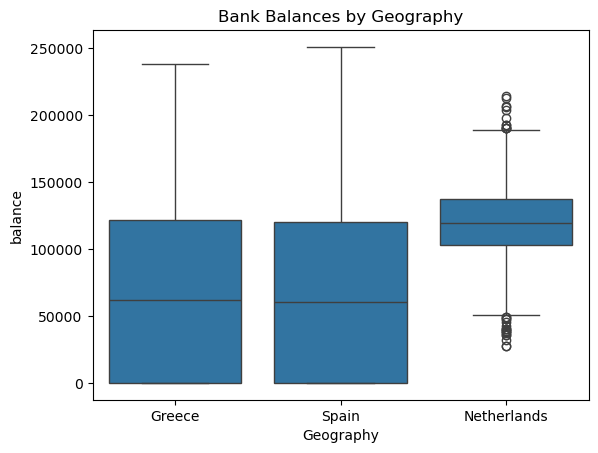

In [38]:
contingency_table = pd.crosstab(df_og['Geography'], df_og['balance'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Squared Test p-value: {p}")

# Visualization
sns.boxplot(x='Geography', y='balance', data=df_og)
plt.title("Bank Balances by Geography")
plt.show()

# Evaluation Scores

In [39]:
def calculate_sse(X, labels):
    sse = 0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        sse += np.sum((cluster_points - centroid) ** 2, axis=0)
    return sse

X_m = df[final_features]
labels = df_og['Final Model Clusters k=3']

score = silhouette_score(X_m, labels)
print(f'Silhouette Score: {score}') # cohesion + separation
score = calculate_sse(X_m, labels)
print(f'Sum of Squared Errors: {score}') # cohesion
score = davies_bouldin_score(X_m, labels)
print(f'Davies-Bouldin Index: {score}') # separation

Silhouette Score: 0.4623521019931329
Sum of Squared Errors: balance             1320.871883
log_Total_income    1373.514561
dtype: float64
Davies-Bouldin Index: 0.9637641677218399


### compare to more complex model

In [40]:
X_c = df[forest_features]
labels_c = df_og['Feature Importance Model Clusters k=4']

score = silhouette_score(X_c, labels_c)
print(f'Silhouette Score: {score}') # cohesion + separation
score = calculate_sse(X_c, labels_c)
print(f'Sum of Squared Errors: {score}') # cohesion
score = davies_bouldin_score(X_c, labels_c)
print(f'Davies-Bouldin Index: {score}') # separation

Silhouette Score: 0.14244243568886128
Sum of Squared Errors: log_age                614.144209
credit_score          9693.442120
balance               3241.972299
Account_length        4728.630603
log_Years_employed    8511.098521
log_Total_income      2261.292277
tenure                5757.477402
dtype: float64
Davies-Bouldin Index: 1.8545333803822848


### Profiles from more complex model

see the graphs earlier, I plotted them under 'models'

<ul>
<li>Cluster 1:</li>
<ul>
<li>More children</li>
<li>Higher percentages of students and pensioners.</li>
<li>Less educated </li>
<li>Less stable employment</li>
<li>Higher tenure</li>
</ul>

<li>Cluster 2:</li>
<ul>
<li>More educated </li>
<li>More years employed - so more stable</li>
<li>Contains a mix of higher-skilled and lower-skilled workers</li>
    </ul>
</ul>


# Visualise Clusters

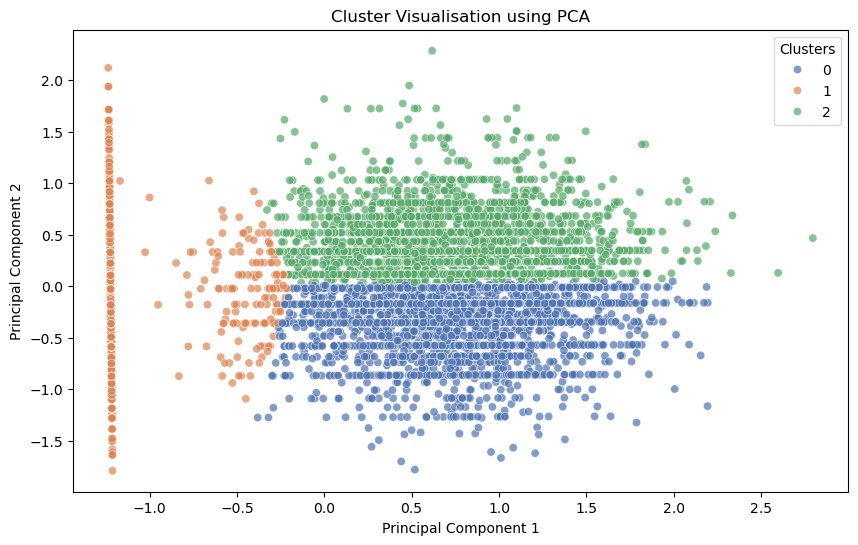

In [41]:
def plot_pca(X, labels):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="deep", alpha=0.7)
    plt.title('Cluster Visualisation using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Clusters', loc='upper right')
    plt.show()

plot_pca(X_m, labels)

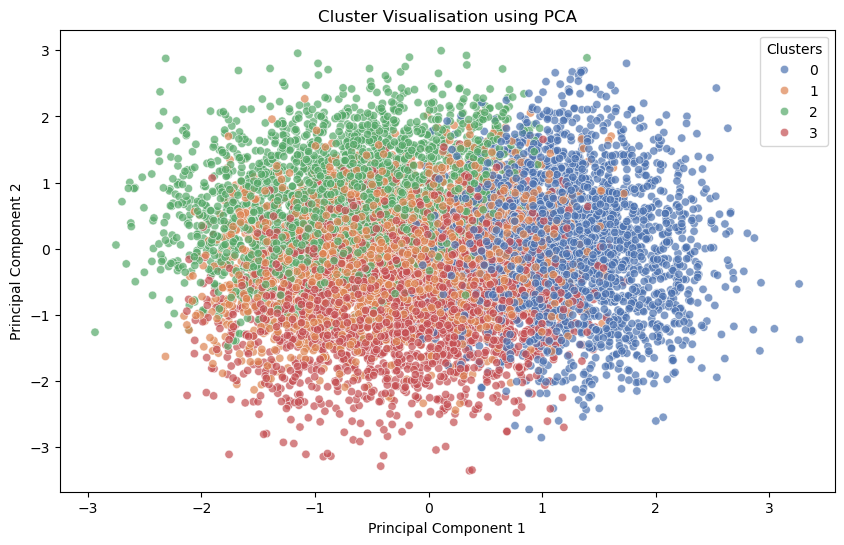

In [42]:
plot_pca(X_c, labels_c)    